In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [4]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [5]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


In [6]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in raw_training_data]

In [8]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [9]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits
EXTRA_POS = False  # Q4 (and Q5)
EXTRA_SUFFIXES = False  # Q5
PREFIXES = False # Q5
PREVIOUS_TOKENS_TAGS = False # Q5
FOLLOWING_TOKENS_TAGS = False # Q5

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # SOLUTION
    # extra features for POS Q4 (+ Q5)
    if EXTRA_POS:
        token, pos = token.split("__")[0], token.split("__")[1]
        feature_list.append("POS_" + pos)
    
    # SOLUTION
    # extra features Q5
    if EXTRA_SUFFIXES:
        for x in range(4, len(token)):
            feature_list.append("SUF_" + token[-x:])
    if PREFIXES:
        for x in range(1, len(token)):
            feature_list.append("PREF_" + token[:x])
    
    if PREVIOUS_TOKENS_TAGS:
        if idx > 0:
            pre_token = tokens[idx-1]
            pre_token, pre_pos = pre_token.split("__")[0], pre_token.split("__")[1]
            feature_list.append("PRETOKEN_" + pre_token)
            feature_list.append("PREPOS_" + pre_pos)
        else:
            feature_list.append("PRETOKEN_<s>")
            feature_list.append("PREPOS_<s>")
    
    if FOLLOWING_TOKENS_TAGS:
        if idx < len(tokens)-1:
            post_token = tokens[idx+1]
            post_token, post_pos = post_token.split("__")[0], post_token.split("__")[1]
            feature_list.append("POSTTOKEN_" + post_token)
            feature_list.append("POSTPOS_" + post_pos)
        else:
            feature_list.append("POSTTOKEN_</s>")
            feature_list.append("POSTPOS_</s>")

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [10]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [11]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [12]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [13]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

          B-ACTOR       0.75      0.88      0.81       812
      B-CHARACTER       0.72      0.26      0.38        90
       B-DIRECTOR       0.78      0.61      0.69       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.60      0.40      0.48       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.87      0.82      0.85       451
         B-REVIEW       0.17      0.02      0.03        56
           B-SONG       0.69      0.17      0.27        54
          B-TITLE       0.58      0.50      0.54       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.75      0.89      0.81       862
      I-CHARACTER       0.76      0.29      0.42        75
       I-DIRECTOR       0.78      0.60      0.68       496
          I-GENRE       0.84      0.71      0.77       

In [14]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

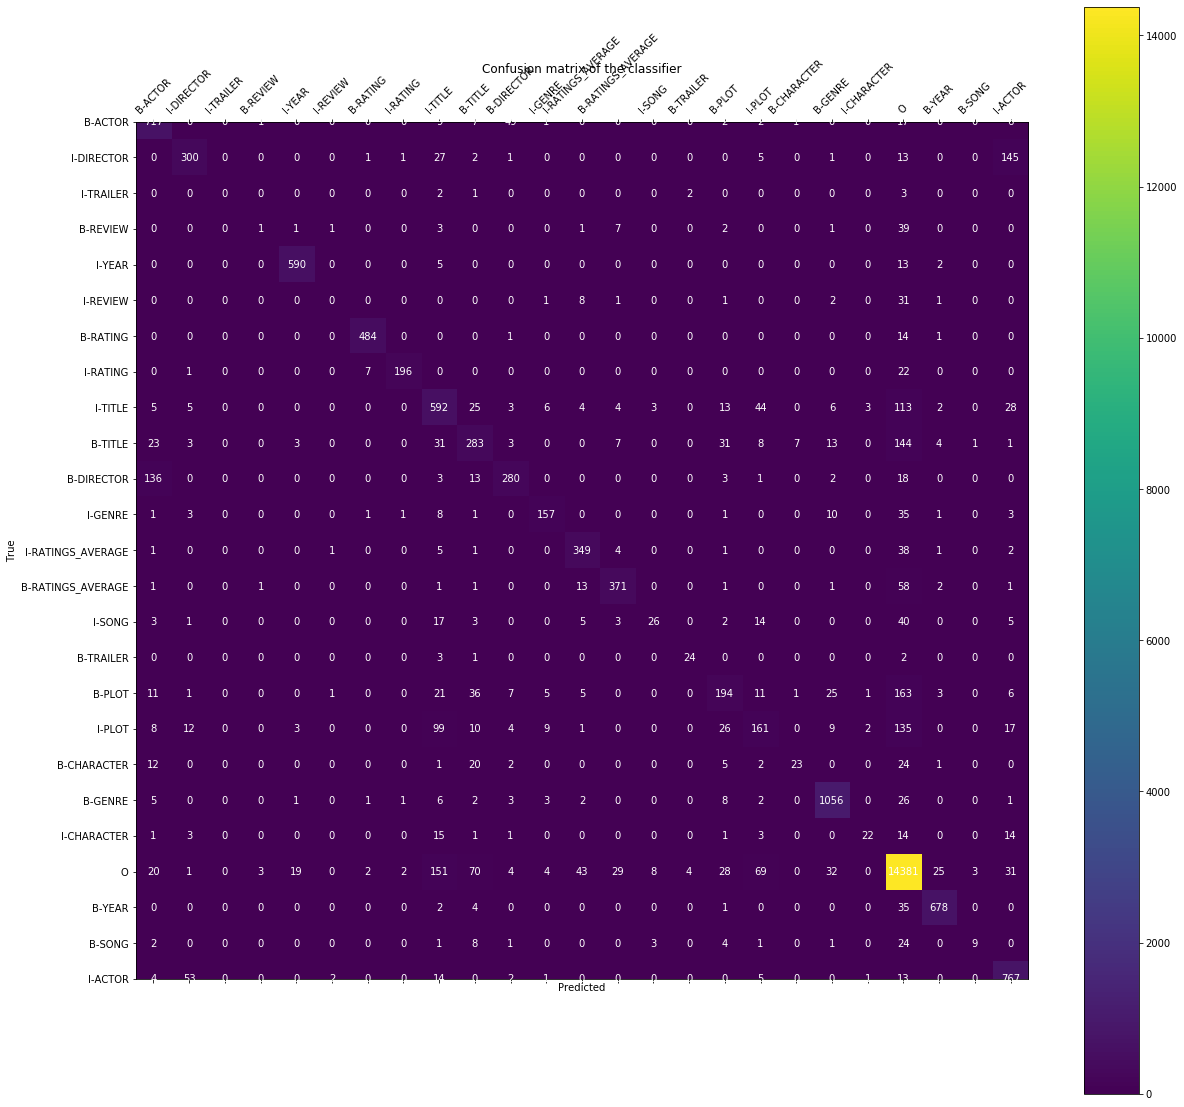

In [15]:
confusion_matrix_heatmap(y_test, preds)

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


In [16]:
split_point = int(0.8 * len(training_data))
new_training_data = training_data[:split_point]
heldout_data = training_data[split_point:]
print(len(new_training_data), "training instances")
print(sum([len(sent) for sent in new_training_data]), "training words")
print(len(heldout_data), "heldout instances")
print(sum([len(sent) for sent in heldout_data]), "heldout words")

7820 training instances
79266 training words
1955 heldout instances
20225 heldout words


In [17]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(new_training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [18]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(heldout_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

1955 instances
20225 words


In [19]:
print("testing tagger...")
preds = []
y_test = []
for sent in heldout_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [20]:
print(classification_report(y_test, preds))

                   precision    recall  f1-score   support

          B-ACTOR       0.65      0.87      0.74       433
      B-CHARACTER       0.70      0.32      0.44        44
       B-DIRECTOR       0.76      0.63      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.48      0.43      0.45       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.88      0.88       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.50      0.25      0.33        20
          B-TITLE       0.66      0.35      0.46       679
        B-TRAILER       1.00      0.50      0.67        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.66      0.85      0.74       482
      I-CHARACTER       0.58      0.60      0.59        47
       I-DIRECTOR       0.76      0.62      0.68       410
          I-GENRE       0.90      1.00      0.95       

# 2. Error analysis 1: False positives (10 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (10 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [21]:
# answers 2 and 3
lowest_precision = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "I-PLOT", "I-SONG"]
lowest_recall = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "B-SONG", "I-SONG"]

def test(data):
    """Returns a list of predictions and list of ground-truth labels.
    Also prints out false positives/negatives for a list of classes"""
    print("testing tagger...")
    preds = []
    y_test = []
    for sent in data:
        sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]

        # Get the false positives in the sentence
        for fp in lowest_precision:
            positions_pred = [i for i, x in enumerate(sent_preds) if x==fp]
            if positions_pred == []:
                continue
            positions_true = [i for i, x in enumerate(sent_true) if x==fp]
            if len(set(positions_pred) - set(positions_true))>0:
                print("false positive!", fp)
                print(set(positions_pred) - set(positions_true))
                print(sent)
                print(sent_preds)
                print("*" * 30)

        # Get the false negatives in the sentence
        for fn in lowest_recall:
            positions_true = [i for i, x in enumerate(sent_true) if x==fn]
            if positions_true == []:
                continue
            positions_pred = [i for i, x in enumerate(sent_preds) if x==fn]
            if len(set(positions_true) - set(positions_pred))>0:
                print("false negative!", fn)
                print(set(positions_true) - set(positions_pred))
                print(sent)
                print(sent_preds)
                print("*" * 30)
        preds.extend(sent_preds)
        y_test.extend(sent_true)
    print("done")
    return preds, y_test

In [22]:
preds, y_test = test(heldout_data)

testing tagger...
false positive! I-PLOT
{10}
[('what', 'O'), ('genre', 'O'), ('is', 'O'), ('the', 'O'), ('movie', 'O'), ('my', 'B-TITLE'), ('date', 'I-TITLE'), ('with', 'I-TITLE'), ('the', 'I-TITLE'), ('presidents', 'I-TITLE'), ('daughter', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{3, 4}
[('what', 'O'), ('is', 'O'), ('becoming', 'B-TITLE'), ('jesse', 'I-TITLE'), ('tate', 'I-TITLE')]
['O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{4}
[('what', 'O'), ('is', 'O'), ('forbidden', 'B-PLOT'), ('love', 'I-PLOT'), ('about', 'O')]
['O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{3}
[('what', 'O'), ('is', 'O'), ('internal', 'B-TITLE'), ('affairs', 'I-TITLE')]
['O', 'O', 'B-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{3, 4, 5, 6}
[('what', 'O'), ('is', 'O'), ('such', 'B-TITLE'), ('hawks'

false positive! I-PLOT
{8, 9}
[('what', 'O'), ('is', 'O'), ('the', 'O'), ('plot', 'O'), ('in', 'O'), ('the', 'O'), ('movie', 'O'), ('princess', 'B-TITLE'), ('of', 'I-TITLE'), ('thieves', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{8, 9, 6, 7}
[('what', 'O'), ('is', 'O'), ('the', 'O'), ('plot', 'O'), ('of', 'O'), ('city', 'B-TITLE'), ('of', 'I-TITLE'), ('life', 'I-TITLE'), ('and', 'I-TITLE'), ('death', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{8}
[('what', 'O'), ('is', 'O'), ('the', 'O'), ('plot', 'O'), ('of', 'O'), ('the', 'O'), ('movie', 'O'), ('posse', 'B-TITLE'), ('cat', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{6, 7}
[('what', 'O'), ('is', 'O'), ('the', 'O'), ('rating', 'O'), ('for', 'O'), ('august', 'B-TITLE'), ('u

false positive! I-PLOT
{8}
[('name', 'O'), ('a', 'O'), ('pg', 'B-RATING'), ('13', 'I-RATING'), ('western', 'B-GENRE'), ('with', 'O'), ('someone', 'O'), ('getting', 'O'), ('thrown', 'B-PLOT'), ('from', 'I-PLOT'), ('a', 'I-PLOT'), ('train', 'I-PLOT')]
['O', 'O', 'B-RATING', 'I-RATING', 'B-GENRE', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{10, 11}
[('what', 'O'), ('is', 'O'), ('a', 'O'), ('very', 'B-RATINGS_AVERAGE'), ('popular', 'I-RATINGS_AVERAGE'), ('r', 'B-RATING'), ('rated', 'O'), ('documentary', 'B-GENRE'), ('with', 'O'), ('geraint', 'B-ACTOR'), ('wyne', 'I-ACTOR'), ('davies', 'I-ACTOR')]
['O', 'O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'B-RATING', 'O', 'B-GENRE', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! B-REVIEW
{3}
[('what', 'O'), ('is', 'O'), ('the', 'O'), ('best', 'O'), ('drama', 'B-GENRE'), ('ever', 'O'), ('directed', 'O'), ('by', 'O'), ('ingmar', 'B-DIRECTO

# 4. Using POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [23]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [24]:
# solution to pre-process
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    words = [x[0] for x in example]
    pos_tags = [x[1] for x in posttagger.tag(words)]
    preprocessed_example = [("{0}__{1}".format(x[0], pos), x[1]) for x, pos in zip(example, pos_tags)]
    return preprocessed_example

In [25]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [26]:
training_data= [preProcess(example) for example in raw_training_data]

In [27]:
split_point = int(0.8 * len(training_data))
new_training_data = training_data[:split_point]
heldout_data = training_data[split_point:]
print(len(new_training_data), "instances")
print(sum([len(sent) for sent in new_training_data]), "words")

7820 instances
79266 words


In [28]:
EXTRA_POS = True

In [29]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(new_training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [30]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(heldout_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

1955 instances
20225 words


In [31]:
lowest_precision = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "I-PLOT", "I-SONG"]
lowest_recall = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "B-SONG", "I-SONG"]
preds, y_test = test(heldout_data)

testing tagger...
false positive! I-PLOT
{10}
[('what__WP', 'O'), ('genre__VBP', 'O'), ('is__VBZ', 'O'), ('the__DT', 'O'), ('movie__NN', 'O'), ('my__PRP$', 'B-TITLE'), ('date__NN', 'I-TITLE'), ('with__IN', 'I-TITLE'), ('the__DT', 'I-TITLE'), ('presidents__NNS', 'I-TITLE'), ('daughter__NN', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{4}
[('what__WP', 'O'), ('has__VBZ', 'O'), ('actor__NN', 'O'), ('adrian__JJ', 'B-ACTOR'), ('pasdar__NN', 'I-ACTOR'), ('done__VBN', 'O'), ('in__IN', 'O'), ('the__DT', 'O'), ('past__JJ', 'B-YEAR'), ('seven__CD', 'I-YEAR'), ('years__NNS', 'I-YEAR')]
['O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'O', 'O', 'O', 'B-YEAR', 'I-YEAR', 'I-YEAR']
******************************
false positive! I-PLOT
{3, 4}
[('what__WP', 'O'), ('is__VBZ', 'O'), ('becoming__VBG', 'B-TITLE'), ('jesse__NN', 'I-TITLE'), ('tate__NN', 'I-TITLE')]
['O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
****************************

false positive! B-REVIEW
{3}
[('what__WP', 'O'), ('was__VBD', 'O'), ('the__DT', 'O'), ('best__JJS', 'O'), ('animation__NN', 'B-GENRE'), ('film__NN', 'O'), ('in__IN', 'O'), ('2010__NNP', 'B-YEAR')]
['O', 'O', 'O', 'B-REVIEW', 'B-GENRE', 'O', 'O', 'B-YEAR']
******************************
false positive! B-REVIEW
{3}
[('what__WP', 'O'), ('was__VBD', 'O'), ('the__DT', 'O'), ('best__JJS', 'O'), ('comedy__NN', 'B-GENRE'), ('movie__NN', 'O'), ('for__IN', 'O'), ('2011__NNP', 'O')]
['O', 'O', 'O', 'B-REVIEW', 'B-GENRE', 'O', 'O', 'B-YEAR']
******************************
false positive! B-REVIEW
{3}
[('what__WP', 'O'), ('was__VBD', 'O'), ('the__DT', 'O'), ('best__JJS', 'O'), ('crime__NN', 'B-GENRE'), ('film__NN', 'O'), ('directed__VBN', 'O'), ('by__IN', 'O'), ('federico__NNP', 'B-DIRECTOR'), ('fellini__NNP', 'I-DIRECTOR')]
['O', 'O', 'O', 'B-REVIEW', 'B-GENRE', 'O', 'O', 'O', 'B-DIRECTOR', 'I-DIRECTOR']
******************************
false positive! B-REVIEW
{3}
[('what__WP', 'O'), ('was__VBD', 

false positive! I-PLOT
{4, 5, 6, 7}
[('who__WP', 'O'), ('stars__NNS', 'O'), ('in__IN', 'O'), ('everybody__NN', 'B-TITLE'), ('wants__VBZ', 'I-TITLE'), ('to__TO', 'I-TITLE'), ('be__VB', 'I-TITLE'), ('italian__JJ', 'I-TITLE')]
['O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{4, 5, 6}
[('who__WP', 'O'), ('stars__NNS', 'O'), ('in__IN', 'O'), ('hail__NN', 'B-TITLE'), ('the__DT', 'I-TITLE'), ('conquering__NN', 'I-TITLE'), ('hero__NN', 'I-TITLE')]
['O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{5}
[('who__WP', 'O'), ('stars__NNS', 'O'), ('in__IN', 'O'), ('the__DT', 'B-TITLE'), ('alphabet__NN', 'I-TITLE'), ('killer__NN', 'I-TITLE')]
['O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{5, 6, 7}
[('who__WP', 'O'), ('stars__NNS', 'O'), ('in__IN', 'O'), ('the__DT', 'B-TITLE'), ('charge__NN', 'I-TITLE'), ('at__IN', 'I-TITLE'

In [32]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                   precision    recall  f1-score   support

          B-ACTOR       0.64      0.85      0.73       433
      B-CHARACTER       0.68      0.34      0.45        44
       B-DIRECTOR       0.75      0.64      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.46      0.47      0.46       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.89      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.54      0.35      0.42        20
          B-TITLE       0.68      0.34      0.45       679
        B-TRAILER       1.00      0.54      0.70        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.65      0.83      0.73       482
      I-CHARACTER       0.55      0.60      0.57        47
       I-DIRECTOR       0.75      0.63      0.69       410
          I-GENRE       0.91      1.00      0.95       

# 5. Feature experimentation for optimal macro average (20 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format. You could try more suffixes/prefixes of the curret word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q1 and Q2 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes. Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `engtest.bio.txt`) as your final piece of code.

In [42]:
EXTRA_SUFFIXES = True  # Q5
PREFIXES = True # Q5
PREVIOUS_TOKENS_TAGS = True # Q5
FOLLOWING_TOKENS_TAGS = True # Q5

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(new_training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(heldout_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

lowest_precision = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "I-PLOT", "I-SONG"]
lowest_recall = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "B-SONG", "I-SONG"]
preds, y_test = test(heldout_data)

print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

training tagger...
done
1955 instances
20225 words
testing tagger...
false positive! B-REVIEW
{1}
[('what__WDT', 'O'), ('fun__NN', 'B-GENRE'), ('movie__NN', 'O'), ('about__RB', 'O'), ('jealousy__JJ', 'B-PLOT'), ('from__IN', 'O'), ('the__DT', 'O'), ('last__JJ', 'B-YEAR'), ('seven__CD', 'I-YEAR'), ('decades__NNS', 'I-YEAR'), ('rated__VBN', 'O'), ('g__NNP', 'B-RATING'), ('was__VBD', 'O'), ('directed__VBN', 'O'), ('by__IN', 'O'), ('john__NNP', 'B-DIRECTOR'), ('humber__NNP', 'I-DIRECTOR')]
['O', 'B-REVIEW', 'O', 'O', 'B-PLOT', 'O', 'O', 'B-YEAR', 'I-YEAR', 'I-YEAR', 'O', 'B-RATING', 'O', 'O', 'O', 'B-DIRECTOR', 'I-DIRECTOR']
******************************
false positive! I-PLOT
{3, 4}
[('what__WP', 'O'), ('is__VBZ', 'O'), ('becoming__VBG', 'B-TITLE'), ('jesse__NN', 'I-TITLE'), ('tate__NN', 'I-TITLE')]
['O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{3}
[('what__WP', 'O'), ('is__VBZ', 'O'), ('dysfunktional__JJ', 'B-TITLE'), ('family__NN', 'I-TIT

false positive! I-PLOT
{16, 17, 15}
[('what__WP', 'O'), ('is__VBZ', 'O'), ('the__DT', 'O'), ('title__NN', 'O'), ('of__IN', 'O'), ('a__DT', 'O'), ('movie__NN', 'O'), ('from__IN', 'O'), ('2000__NNP', 'B-YEAR'), ('starring__NNP', 'O'), ('matthew__NNP', 'B-ACTOR'), ('mcconaughey__NNP', 'I-ACTOR'), ('in__IN', 'O'), ('which__WDT', 'O'), ('he__PRP', 'O'), ('is__VBZ', 'O'), ('a__DT', 'O'), ('prisoner__NN', 'B-PLOT'), ('and__CC', 'O'), ('which__WDT', 'O'), ('was__VBD', 'O'), ('pg__NNP', 'B-RATING'), ('13__NNP', 'I-RATING'), ('and__CC', 'O'), ('had__VBD', 'O'), ('an__DT', 'O'), ('eight__CD', 'B-RATINGS_AVERAGE'), ('stars__NNS', 'I-RATINGS_AVERAGE'), ('rating__VBG', 'O')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-YEAR', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'O', 'O', 'O', 'B-RATING', 'I-RATING', 'O', 'O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'O']
******************************
false positive! B-REVIEW
{3}
[('what__WP', 'O'), ('is__VBZ', 'O'), ('t

false negative! B-REVIEW
{4}
[('what__WP', 'O'), ('did__VBD', 'O'), ('you__PRP', 'O'), ('really__RB', 'O'), ('think__VBP', 'B-REVIEW'), ('about__IN', 'O'), ('evita__NNP', 'B-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT']
******************************
false negative! B-REVIEW
{3}
[('what__WP', 'O'), ('did__VBD', 'O'), ('you__PRP', 'O'), ('think__VBP', 'B-REVIEW'), ('was__VBD', 'O'), ('an__DT', 'O'), ('awesome__NN', 'O'), ('part__NN', 'O'), ('in__IN', 'O'), ('it__PRP', 'O')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
******************************
false positive! I-PLOT
{9, 10, 11}
[('what__WP', 'O'), ('do__VBP', 'O'), ('you__PRP', 'O'), ('think__VBP', 'B-REVIEW'), ('of__IN', 'O'), ('the__DT', 'O'), ('movie__NN', 'O'), ('a__DT', 'B-TITLE'), ('hard__JJ', 'I-TITLE'), ('day__NN', 'I-TITLE'), ('s__NNP', 'I-TITLE'), ('night__NN', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false negative! B-REVIEW
{3}


                   precision    recall  f1-score   support

          B-ACTOR       0.86      0.95      0.90       433
      B-CHARACTER       0.75      0.34      0.47        44
       B-DIRECTOR       0.96      0.91      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.80      0.86      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.89      0.40      0.55        20
          B-TITLE       0.84      0.65      0.73       679
        B-TRAILER       1.00      0.36      0.53        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.85      0.93      0.89       482
      I-CHARACTER       0.69      0.23      0.35        47
       I-DIRECTOR       0.96      0.90      0.92       410
          I-GENRE       0.94      1.00      0.97       

In [45]:
print("""Original results on heldout data:

      precision    recall  f1-score   support

          B-ACTOR       0.65      0.87      0.74       433
      B-CHARACTER       0.70      0.32      0.44        44
       B-DIRECTOR       0.76      0.63      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.48      0.43      0.45       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.88      0.88       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.50      0.25      0.33        20
          B-TITLE       0.66      0.35      0.46       679
        B-TRAILER       1.00      0.50      0.67        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.66      0.85      0.74       482
      I-CHARACTER       0.58      0.60      0.59        47
       I-DIRECTOR       0.76      0.62      0.68       410
          I-GENRE       0.90      1.00      0.95       123
           I-PLOT       0.28      0.64      0.39       148
         I-RATING       0.98      1.00      0.99       156
I-RATINGS_AVERAGE       0.76      0.94      0.84       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.29      0.23      0.26        43
          I-TITLE       0.75      0.48      0.58      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.95      1.00      0.98       528
                O       0.94      0.96      0.95     12447

         accuracy                           0.88     20225
        macro avg       0.65      0.62      0.62     20225
     weighted avg       0.88      0.88      0.87     20225
     
""")
     
     
print("""Including POS feature for each word (Q4)

precision    recall  f1-score   support

          B-ACTOR       0.64      0.85      0.73       433
      B-CHARACTER       0.68      0.34      0.45        44
       B-DIRECTOR       0.75      0.64      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.46      0.47      0.46       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.89      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.54      0.35      0.42        20
          B-TITLE       0.68      0.34      0.45       679
        B-TRAILER       1.00      0.54      0.70        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.65      0.83      0.73       482
      I-CHARACTER       0.55      0.60      0.57        47
       I-DIRECTOR       0.75      0.63      0.69       410
          I-GENRE       0.91      1.00      0.95       123
           I-PLOT       0.25      0.64      0.36       148
         I-RATING       0.98      1.00      0.99       156
I-RATINGS_AVERAGE       0.78      0.93      0.85       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.31      0.35      0.33        43
          I-TITLE       0.82      0.47      0.60      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.96      1.00      0.98       528
                O       0.94      0.96      0.95     12447

         accuracy                           0.88     20225
        macro avg       0.66      0.63      0.63     20225
     weighted avg       0.88      0.88      0.88     20225

""")

print("""
Trying Extra Suffixes (Q5)

       precision    recall  f1-score   support

          B-ACTOR       0.69      0.89      0.78       433
      B-CHARACTER       0.70      0.36      0.48        44
       B-DIRECTOR       0.77      0.65      0.71       365
          B-GENRE       0.97      0.98      0.98       927
           B-PLOT       0.56      0.62      0.59       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.89      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.47      0.35      0.40        20
          B-TITLE       0.69      0.36      0.47       679
        B-TRAILER       1.00      0.54      0.70        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.70      0.87      0.78       482
      I-CHARACTER       0.57      0.62      0.59        47
       I-DIRECTOR       0.78      0.66      0.72       410
          I-GENRE       0.92      1.00      0.96       123
           I-PLOT       0.30      0.72      0.43       148
         I-RATING       0.98      1.00      0.99       156
I-RATINGS_AVERAGE       0.78      0.94      0.85       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.25      0.35      0.29        43
          I-TITLE       0.83      0.48      0.61      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.96      1.00      0.98       528
                O       0.94      0.97      0.96     12447

         accuracy                           0.89     20225
        macro avg       0.67      0.65      0.64     20225
     weighted avg       0.89      0.89      0.89     20225

(0.6680976019393492, 0.6500219813082245, 0.6443535421128941, None)

""")


print("""Trying prefixes (Q5)

            precision    recall  f1-score   support

          B-ACTOR       0.71      0.88      0.79       433
      B-CHARACTER       0.50      0.20      0.29        44
       B-DIRECTOR       0.79      0.66      0.72       365
          B-GENRE       0.98      0.99      0.98       927
           B-PLOT       0.63      0.73      0.67       298
         B-RATING       0.99      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.90      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.37      0.35      0.36        20
          B-TITLE       0.72      0.42      0.53       679
        B-TRAILER       1.00      0.43      0.60        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.71      0.87      0.78       482
      I-CHARACTER       0.44      0.15      0.22        47
       I-DIRECTOR       0.79      0.66      0.72       410
          I-GENRE       0.92      1.00      0.96       123
           I-PLOT       0.34      0.80      0.48       148
         I-RATING       0.98      1.00      0.99       156
I-RATINGS_AVERAGE       0.80      0.95      0.87       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.31      0.40      0.35        43
          I-TITLE       0.80      0.53      0.63      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.97      1.00      0.98       528
                O       0.95      0.97      0.96     12447

         accuracy                           0.90     20225
        macro avg       0.66      0.64      0.63     20225
     weighted avg       0.90      0.90      0.89     20225

(0.6611549925324499, 0.6357443430942754, 0.630207614956414, None)

""")


print("""Trying prefixes and suffixes (Q5)

 precision    recall  f1-score   support

          B-ACTOR       0.73      0.88      0.80       433
      B-CHARACTER       0.55      0.27      0.36        44
       B-DIRECTOR       0.77      0.68      0.72       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.61      0.75      0.67       298
         B-RATING       0.99      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.91      0.90       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.35      0.35      0.35        20
          B-TITLE       0.71      0.39      0.50       679
        B-TRAILER       1.00      0.36      0.53        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.72      0.87      0.79       482
      I-CHARACTER       0.52      0.34      0.41        47
       I-DIRECTOR       0.77      0.68      0.72       410
          I-GENRE       0.92      1.00      0.96       123
           I-PLOT       0.34      0.81      0.47       148
         I-RATING       0.99      1.00      0.99       156
I-RATINGS_AVERAGE       0.80      0.96      0.87       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.27      0.35      0.30        43
          I-TITLE       0.81      0.51      0.62      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.97      1.00      0.98       528
                O       0.95      0.97      0.96     12447

         accuracy                           0.90     20225
        macro avg       0.66      0.64      0.64     20225
     weighted avg       0.90      0.90      0.89     20225

(0.6629003014860986, 0.6423516403029046, 0.635195189172016, None)

""")

print("""Trying suffixes with previous word/POS tag (Q5)

                    precision    recall  f1-score   support

          B-ACTOR       0.81      0.93      0.86       433
      B-CHARACTER       0.74      0.39      0.51        44
       B-DIRECTOR       0.93      0.89      0.91       365
          B-GENRE       0.98      0.95      0.96       927
           B-PLOT       0.74      0.72      0.73       298
         B-RATING       1.00      0.99      0.99       430
B-RATINGS_AVERAGE       0.91      0.91      0.91       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.78      0.35      0.48        20
          B-TITLE       0.81      0.58      0.68       679
        B-TRAILER       1.00      0.32      0.49        28
           B-YEAR       0.94      0.99      0.97       535
          I-ACTOR       0.81      0.91      0.86       482
      I-CHARACTER       0.62      0.55      0.58        47
       I-DIRECTOR       0.93      0.87      0.90       410
          I-GENRE       0.94      1.00      0.97       123
           I-PLOT       0.50      0.82      0.62       148
         I-RATING       0.97      1.00      0.98       156
I-RATINGS_AVERAGE       0.86      0.93      0.89       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.77      0.40      0.52        43
          I-TITLE       0.89      0.66      0.76      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.96      0.99      0.97       528
                O       0.95      0.97      0.96     12447

         accuracy                           0.92     20225
        macro avg       0.75      0.68      0.70     20225
     weighted avg       0.92      0.92      0.92     20225

(0.7527972509212659, 0.6848150844053303, 0.7003402920459696, None)
      
      
""")

print("""Trying suffixes, previous word/POS tag, and following word/POS tag (Q5)

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.94      0.89       433
      B-CHARACTER       0.83      0.45      0.59        44
       B-DIRECTOR       0.94      0.90      0.92       365
          B-GENRE       0.97      0.95      0.96       927
           B-PLOT       0.80      0.79      0.79       298
         B-RATING       0.99      0.99      0.99       430
B-RATINGS_AVERAGE       0.92      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.78      0.35      0.48        20
          B-TITLE       0.83      0.61      0.71       679
        B-TRAILER       1.00      0.14      0.25        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.83      0.92      0.87       482
      I-CHARACTER       0.64      0.60      0.62        47
       I-DIRECTOR       0.94      0.88      0.91       410
          I-GENRE       0.94      1.00      0.97       123
           I-PLOT       0.55      0.85      0.67       148
         I-RATING       0.99      1.00      0.99       156
I-RATINGS_AVERAGE       0.88      0.95      0.91       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.81      0.40      0.53        43
          I-TITLE       0.90      0.69      0.78      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.96      1.00      0.98       528
                O       0.95      0.98      0.97     12447

         accuracy                           0.93     20225
        macro avg       0.77      0.69      0.71     20225
     weighted avg       0.93      0.93      0.93     20225

(0.7702475147872029, 0.6931714774829413, 0.7075722229221222, None)

""")

print("""
Trying suffixes, prefixes, previous word/POS tag and following word/POS tag (Q5)

                   precision    recall  f1-score   support

          B-ACTOR       0.86      0.95      0.90       433
      B-CHARACTER       0.75      0.34      0.47        44
       B-DIRECTOR       0.96      0.91      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.80      0.86      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.89      0.40      0.55        20
          B-TITLE       0.84      0.65      0.73       679
        B-TRAILER       1.00      0.36      0.53        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.85      0.93      0.89       482
      I-CHARACTER       0.69      0.23      0.35        47
       I-DIRECTOR       0.96      0.90      0.92       410
          I-GENRE       0.94      1.00      0.97       123
           I-PLOT       0.51      0.86      0.64       148
         I-RATING       0.99      1.00      0.99       156
I-RATINGS_AVERAGE       0.88      0.96      0.92       408
         I-REVIEW       0.00      0.00      0.00         9
           I-SONG       0.94      0.40      0.56        43
          I-TITLE       0.89      0.71      0.79      1182
        I-TRAILER       0.00      0.00      0.00         1
           I-YEAR       0.97      1.00      0.98       528
                O       0.96      0.98      0.97     12447

         accuracy                           0.94     20225
        macro avg       0.78      0.69      0.71     20225
     weighted avg       0.94      0.94      0.94     20225

(0.7809933779212844, 0.694038715767699, 0.7125455839298013, None)
""")    


Original results on heldout data:

      precision    recall  f1-score   support

          B-ACTOR       0.65      0.87      0.74       433
      B-CHARACTER       0.70      0.32      0.44        44
       B-DIRECTOR       0.76      0.63      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.48      0.43      0.45       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.88      0.88       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.50      0.25      0.33        20
          B-TITLE       0.66      0.35      0.46       679
        B-TRAILER       1.00      0.50      0.67        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.66      0.85      0.74       482
      I-CHARACTER       0.58      0.60      0.59        47
       I-DIRECTOR       0.76      0.62      0.68       410
          I-GENRE       0.90     

In [46]:
# Final results on original test data:
# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

EXTRA_POS = False  # Turn off extra POS
EXTRA_FEATURES = True  # Turn on extra features

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

lowest_precision = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "I-PLOT", "I-SONG"]
lowest_recall = ["B-REVIEW", "I-REVIEW", "I-TRAILER", "B-SONG", "I-SONG"]
preds, y_test = test(test_data)

2443 instances
24686 words
training tagger...
done
2443 instances
20225 words
testing tagger...
false negative! B-SONG
{4}
[('can__MD', 'O'), ('you__PRP', 'O'), ('get__VBP', 'O'), ('a__DT', 'O'), ('soundtrac__NN', 'B-SONG'), ('for__IN', 'O'), ('the__DT', 'O'), ('harry__NN', 'B-TITLE'), ('potter__NN', 'I-TITLE'), ('films__NNS', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TITLE', 'I-TITLE', 'O']
******************************
false negative! B-REVIEW
{3}
[('what__WP', 'O'), ('was__VBD', 'O'), ('the__DT', 'O'), ('best__JJS', 'B-REVIEW'), ('rated__VBN', 'O'), ('stanley__NNP', 'B-DIRECTOR'), ('kubrick__NNP', 'I-DIRECTOR'), ('film__NN', 'O')]
['O', 'O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'B-DIRECTOR', 'I-DIRECTOR', 'O']
******************************
false negative! B-REVIEW
{4}
[('may__MD', 'O'), ('i__PRP', 'O'), ('have__VBP', 'O'), ('the__DT', 'O'), ('highly__RB', 'B-REVIEW'), ('acclaimed__JJ', 'I-REVIEW'), ('film__NN', 'O'), ('from__IN', 'O'), ('1985__NNP', 'B-RATINGS_A

false positive! I-PLOT
{4, 5, 6}
[('disney__NNP', 'B-PLOT'), ('cartoon__NNP', 'I-PLOT'), ('with__IN', 'O'), ('classical__JJ', 'O'), ('music__NN', 'O'), ('and__CC', 'O'), ('animals__NNS', 'O')]
['B-ACTOR', 'I-ACTOR', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false negative! B-REVIEW
{2}
[('whats__WPBES', 'O'), ('the__DT', 'O'), ('highest__JJS', 'B-REVIEW'), ('rated__VBN', 'I-REVIEW'), ('drama__NNP', 'B-GENRE'), ('of__IN', 'O'), ('1990__NNP', 'B-YEAR')]
['O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'B-GENRE', 'O', 'B-YEAR']
******************************
false negative! I-REVIEW
{3}
[('whats__WPBES', 'O'), ('the__DT', 'O'), ('highest__JJS', 'B-REVIEW'), ('rated__VBN', 'I-REVIEW'), ('drama__NNP', 'B-GENRE'), ('of__IN', 'O'), ('1990__NNP', 'B-YEAR')]
['O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'B-GENRE', 'O', 'B-YEAR']
******************************
false positive! I-PLOT
{8, 9, 10, 11}
[('what__WP', 'O'), ('movies__NNS', 'O'), ('have__VBP'

false positive! I-PLOT
{12}
[('find__VB', 'O'), ('the__DT', 'O'), ('movie__NN', 'O'), ('starring__VBG', 'O'), ('jack__NNP', 'B-ACTOR'), ('lemmon__NNP', 'I-ACTOR'), ('and__CC', 'O'), ('alan__NNP', 'B-ACTOR'), ('arkin__NNP', 'I-ACTOR'), ('as__RB', 'O'), ('real__RB', 'O'), ('estate__JJ', 'O'), ('salesmen__NNS', 'O')]
['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'O', 'B-PLOT', 'I-PLOT']
******************************
false negative! B-REVIEW
{5}
[('what__WDT', 'O'), ('movie__NN', 'O'), ('won__VBD', 'O'), ('the__DT', 'O'), ('most__JJS', 'O'), ('awards__NNS', 'B-REVIEW')]
['O', 'O', 'O', 'O', 'O', 'O']
******************************
false positive! B-REVIEW
{4}
[('what__WP', 'O'), ('are__VBP', 'O'), ('roger__JJR', 'B-RATINGS_AVERAGE'), ('eberts__NNS', 'I-RATINGS_AVERAGE'), ('best__JJS', 'I-RATINGS_AVERAGE'), ('films__NNS', 'I-RATINGS_AVERAGE')]
['O', 'O', 'B-ACTOR', 'I-ACTOR', 'B-REVIEW', 'O']
******************************
false negative! B-SONG
{2}
[('name__NN

false positive! I-PLOT
{9}
[('do__VBP', 'O'), ('you__PRP', 'O'), ('have__VBP', 'O'), ('the__DT', 'O'), ('film__NN', 'O'), ('the__DT', 'B-TITLE'), ('loss__NN', 'I-TITLE'), ('of__IN', 'I-TITLE'), ('sexual__JJ', 'I-TITLE'), ('innocence__NN', 'I-TITLE')]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{5, 6}
[('give__VB', 'O'), ('me__PRP', 'O'), ('info__VBP', 'O'), ('about__RB', 'O'), ('bright__JJ', 'B-TITLE'), ('young__JJ', 'I-TITLE'), ('things__NNS', 'I-TITLE')]
['O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{15}
[('is__VBZ', 'O'), ('there__RB', 'O'), ('a__DT', 'O'), ('movie__NN', 'O'), ('with__IN', 'O'), ('director__NNP', 'O'), ('charles__NNP', 'B-DIRECTOR'), ('stewart__NNP', 'I-DIRECTOR'), ('in__IN', 'O'), ('the__DT', 'O'), ('past__JJ', 'B-YEAR'), ('seven__CD', 'I-YEAR'), ('years__NNS', 'I-YEAR'), ('on__IN', 'O'), ('military__JJ', 'B-GENRE'), ('bravery__NN', 'B-P

false positive! I-PLOT
{16}
[('what__WP', 'O'), ('rated__VBD', 'O'), ('r__NN', 'B-RATING'), ('movie__NN', 'O'), ('directed__VBN', 'O'), ('by__IN', 'O'), ('edward__NNP', 'B-DIRECTOR'), ('zwick__NNP', 'I-DIRECTOR'), ('was__VBD', 'O'), ('based__VBN', 'O'), ('on__IN', 'O'), ('the__DT', 'O'), ('post__NN', 'B-PLOT'), ('world__NN', 'I-PLOT'), ('war__NN', 'I-PLOT'), ('one__CD', 'I-PLOT'), ('era__NN', 'O')]
['O', 'O', 'B-RATING', 'O', 'O', 'O', 'B-DIRECTOR', 'I-DIRECTOR', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{7}
[('where__WRB', 'O'), ('is__VBZ', 'O'), ('the__DT', 'O'), ('movie__NN', 'O'), ('hachiko__IN', 'B-TITLE'), ('a__DT', 'I-TITLE'), ('dogs__NNS', 'I-TITLE'), ('story__NN', 'I-TITLE'), ('set__VBN', 'O')]
['O', 'O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'O']
******************************
false positive! I-PLOT
{5, 6, 7}
[('who__WP', 'O'), ('starred__VBD', 'O'), ('in__IN', 'O'), ('a__DT', 'B-TITLE'), ('th

In [47]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                   precision    recall  f1-score   support

          B-ACTOR       0.89      0.93      0.91       812
      B-CHARACTER       0.80      0.49      0.61        90
       B-DIRECTOR       0.92      0.83      0.87       456
          B-GENRE       0.93      0.95      0.94      1117
           B-PLOT       0.72      0.65      0.68       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.93      0.88      0.91       451
         B-REVIEW       0.50      0.12      0.20        56
           B-SONG       0.67      0.44      0.53        54
          B-TITLE       0.76      0.76      0.76       562
        B-TRAILER       0.81      0.87      0.84        30
           B-YEAR       0.95      0.94      0.95       720
          I-ACTOR       0.87      0.93      0.90       862
      I-CHARACTER       0.74      0.43      0.54        75
       I-DIRECTOR       0.91      0.83      0.87       496
          I-GENRE       0.85      0.71      0.78       